# Testing the models:

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

In [2]:
X = np.load("../train_test_data/train_x_values.npy")
y = np.load("../train_test_data/train_y_values.npy")

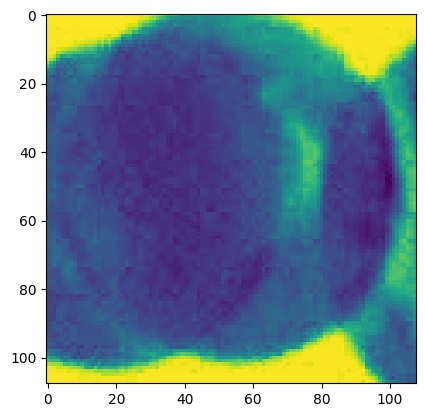

In [3]:
plt.imshow(X[500])

## Encoding the target

In [4]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(y.reshape(-1,1))

OneHotEncoder(sparse=False)

In [5]:
y_encoded = ohe.transform(y.reshape(-1,1))# Display the detected categories
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")

The categories detected by the OneHotEncoder are [array(['gametocyte', 'leukocyte', 'red blood cell', 'ring', 'schizont',
       'trophozoite'], dtype='<U14')]


In [6]:
y_encoded_df=pd.DataFrame(y_encoded, columns = ohe.get_feature_names_out())

In [7]:
y_encoded_df

,x0_gametocyte,x0_leukocyte,x0_red blood cell,x0_ring,x0_schizont,x0_trophozoite
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
995,0.0,0.0,1.0,0.0,0.0,0.0
996,0.0,0.0,1.0,0.0,0.0,0.0
997,0.0,0.0,1.0,0.0,0.0,0.0
998,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
y_encoded.shape

(1000, 6)

## Enconding the test target

In [9]:
X_test = np.load("../train_test_data/test_x_values.npy")
y_test = np.load("../train_test_data/test_y_values.npy")

In [10]:
y_test_encoded = ohe.transform(y_test.reshape(-1,1))

## Balancing the data using class weights

In [11]:
from sklearn.utils import class_weight

In [12]:
cw = y_encoded_df.sum().to_dict()
cw

{'x0_gametocyte': 3.0,
 'x0_leukocyte': 2.0,
 'x0_red blood cell': 972.0,
 'x0_ring': 5.0,
 'x0_schizont': 2.0,
 'x0_trophozoite': 16.0}

In [13]:
(np.unique(y_encoded, axis = 0))

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [14]:
cwv = class_weight.compute_class_weight('balanced', 
                            classes = np.unique(y),
                            y=y)

In [15]:
z = zip([int(i) for i in (np.arange(0,7))], 
            cwv)
np.unique(y_encoded)
[int(i) for i in (np.arange(0,7))]
weighting = dict(z)
weighting

{0: 55.55555555555556,
 1: 83.33333333333333,
 2: 0.17146776406035666,
 3: 33.333333333333336,
 4: 83.33333333333333,
 5: 10.416666666666666}

In [16]:
X_expanded = np.expand_dims(X,axis=3)
image_shape = (X_expanded.shape[1], X_expanded.shape[2], X_expanded.shape[3])

In [17]:
X_expanded=X_expanded/255 #.shape

# Model1 - without regularization and single convolution layer before Max Pooling:

In [18]:
# ARCHITECTURE imports
import numpy as np
from tensorflow.keras import  Sequential, layers, regularizers

In [19]:
#### 1. ARCHITECTURE

model1 = Sequential()

model1.add(layers.Conv2D(filters=36, kernel_size=(5,5), input_shape=image_shape, activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))


model1.add(layers.Dropout(0.5))
#model1.add(layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

#model1.add(layers.Conv2D(filters=10, kernel_size=(2,2), activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)))
model1.add(layers.Conv2D(filters=20, kernel_size=(2,2), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

#model1.add(layers.Flatten())

model1.add(layers.Dense(64, activation='relu'))

model1.add(layers.Dropout(0.2))

model1.add(layers.Flatten())

model1.add(layers.Dense(6, activation='softmax'))

2023-03-09 16:37:44.713805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 16:37:44.811800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 16:37:44.813636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 16:37:44.820367: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
# COMPILATION imports

from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.metrics import Recall

#### 2. COMPILATION

# adam = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
# adam = optimizers.Adam(learning_rate=0.1)
adam = optimizers.Adam()

model1.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy', Recall()])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 104, 104, 36)      936       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 52, 52, 36)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 52, 52, 36)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 36)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 20)        2900      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 20)       0

In [21]:
# FIT imports

from tensorflow.keras import callbacks

#### 3. FIT

es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

history1 = model1.fit(X_expanded, y_encoded,
           batch_size=32, # Batch size -too small--> no generalization
           epochs=500,    #            -too large--> slow computations
           validation_split=0.2,
           callbacks=[es],
           class_weight = weighting,
           verbose=0)


2023-03-09 16:37:49.463323: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


In [22]:
from matplotlib import colors 
def plot_loss(history1, label, n):
   plt.semilogy(history1.epoch, history1.history['loss'],
                color='b', label='Train ' + label)
   plt.semilogy(history1.epoch, history1.history['val_loss'],
                color='r', label='Val ' + label,
                linestyle="--")
   plt.xlabel('Epoch')
   plt.ylabel('Loss')

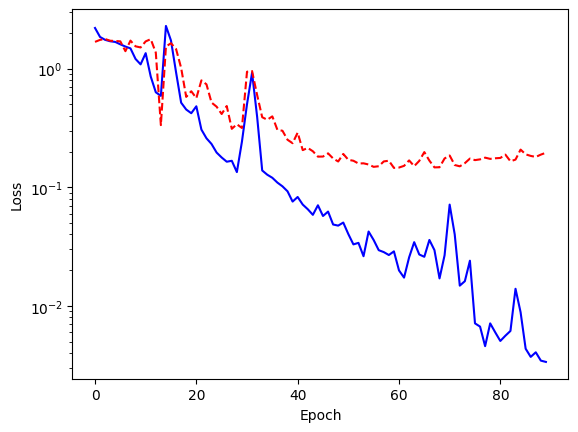

In [23]:
plot_loss(history1,"first run",'b')

In [24]:
min(history1.history['loss'])

0.0033652991987764835

In [25]:
len(history1.history['loss'])

90

In [26]:
model1.evaluate(X_test/255, y_test_encoded)

149/149 [==============================] - 1s 6ms/step - loss: 0.5020 - accuracy: 0.9383 - recall: 0.9102


[0.501970112323761, 0.9383001327514648, 0.9101783633232117]